In [1]:
import numpy as np 
import pandas as pd
import scipy as scipy
import datetime as dt
from sklearn.model_selection import train_test_split
import lightgbm as lgbm
import os
import gc

In [2]:
# Reading Data
train_df =  pd.read_csv('train.csv', nrows = 22000000)

In [3]:
#Drop rows with null values
train_df = train_df.dropna(how = 'any', axis = 'rows')

In [4]:
train_df.shape

(10, 8)

In [5]:
def clean_df(df):
    return df[(df.fare_amount > 0)  & (df.fare_amount <= 500) &
          # (df.passenger_count >= 0) & (df.passenger_count <= 8)  &
           ((df.pickup_longitude != 0) & (df.pickup_latitude != 0) & (df.dropoff_longitude != 0) & (df.dropoff_latitude != 0) )]


In [6]:
train_df = clean_df(train_df)

In [7]:
train_df.shape

(10, 8)

In [8]:
# To Compute Haversine distance
def sphere_dist(pickup_lat, pickup_lon, dropoff_lat, dropoff_lon):
    """
    Return distance along great radius between pickup and dropoff coordinates.
    """
    #Define earth radius (km)
    R_earth = 6371
    #Convert degrees to radians
    pickup_lat, pickup_lon, dropoff_lat, dropoff_lon = map(np.radians,
                                                             [pickup_lat, pickup_lon, 
                                                              dropoff_lat, dropoff_lon])
    #Compute distances along lat, lon dimensions
    dlat = dropoff_lat - pickup_lat
    dlon = dropoff_lon - pickup_lon
    
    #Compute haversine distance
    a = np.sin(dlat/2.0)**2 + np.cos(pickup_lat) * np.cos(dropoff_lat) * np.sin(dlon/2.0)**2
    return 2 * R_earth * np.arcsin(np.sqrt(a))

In [9]:
def sphere_dist_bear(pickup_lat, pickup_lon, dropoff_lat, dropoff_lon):
    """
    Return distance along great radius between pickup and dropoff coordinates.
    """
    #Define earth radius (km)
    R_earth = 6371
    #Convert degrees to radians
    pickup_lat, pickup_lon, dropoff_lat, dropoff_lon = map(np.radians,
                                                             [pickup_lat, pickup_lon, 
                                                              dropoff_lat, dropoff_lon])
    #Compute distances along lat, lon dimensions
    dlat = dropoff_lat - pickup_lat
    dlon = pickup_lon - dropoff_lon
    
    #Compute bearing distance
    a = np.arctan2(np.sin(dlon * np.cos(dropoff_lat)),np.cos(pickup_lat) * np.sin(dropoff_lat) - np.sin(pickup_lat) * np.cos(dropoff_lat) * np.cos(dlon))
    return a

In [10]:
def radian_conv(degree):
    """
    Return radian.
    """
    return  np.radians(degree)  

In [11]:
def add_datetime_info(dataset):
    #Convert to datetime format
    dataset['pickup_datetime'] = pd.to_datetime(dataset['pickup_datetime'],format="%Y-%m-%d %H:%M:%S UTC")
    
    dataset['hour'] = dataset.pickup_datetime.dt.hour
    dataset['day'] = dataset.pickup_datetime.dt.day
    dataset['month'] = dataset.pickup_datetime.dt.month
    dataset['weekday'] = dataset.pickup_datetime.dt.weekday
    dataset['year'] = dataset.pickup_datetime.dt.year
    
    return dataset

In [12]:
def add_airport_dist(dataset):
    """
    Return minumum distance from pickup or dropoff coordinates to each airport.
    JFK: John F. Kennedy International Airport
    EWR: Newark Liberty International Airport
    LGA: LaGuardia Airport
    SOL: Statue of Liberty 
    NYC: Newyork Central
    """
    jfk_coord = (40.639722, -73.778889)
    ewr_coord = (40.6925, -74.168611)
    lga_coord = (40.77725, -73.872611)
    sol_coord = (40.6892,-74.0445) # Statue of Liberty
    nyc_coord = (40.7141667,-74.0063889) 
    
    
    pickup_lat = dataset['pickup_latitude']
    dropoff_lat = dataset['dropoff_latitude']
    pickup_lon = dataset['pickup_longitude']
    dropoff_lon = dataset['dropoff_longitude']
    
    pickup_jfk = sphere_dist(pickup_lat, pickup_lon, jfk_coord[0], jfk_coord[1]) 
    dropoff_jfk = sphere_dist(jfk_coord[0], jfk_coord[1], dropoff_lat, dropoff_lon) 
    pickup_ewr = sphere_dist(pickup_lat, pickup_lon, ewr_coord[0], ewr_coord[1])
    dropoff_ewr = sphere_dist(ewr_coord[0], ewr_coord[1], dropoff_lat, dropoff_lon) 
    pickup_lga = sphere_dist(pickup_lat, pickup_lon, lga_coord[0], lga_coord[1]) 
    dropoff_lga = sphere_dist(lga_coord[0], lga_coord[1], dropoff_lat, dropoff_lon)
    pickup_sol = sphere_dist(pickup_lat, pickup_lon, sol_coord[0], sol_coord[1]) 
    dropoff_sol = sphere_dist(sol_coord[0], sol_coord[1], dropoff_lat, dropoff_lon)
    pickup_nyc = sphere_dist(pickup_lat, pickup_lon, nyc_coord[0], nyc_coord[1]) 
    dropoff_nyc = sphere_dist(nyc_coord[0], nyc_coord[1], dropoff_lat, dropoff_lon)
    
    
    
    dataset['jfk_dist'] = pickup_jfk + dropoff_jfk
    dataset['ewr_dist'] = pickup_ewr + dropoff_ewr
    dataset['lga_dist'] = pickup_lga + dropoff_lga
    dataset['sol_dist'] = pickup_sol + dropoff_sol
    dataset['nyc_dist'] = pickup_nyc + dropoff_nyc
    
    return dataset

In [13]:
train_df = add_datetime_info(train_df)
train_df = add_airport_dist(train_df)
train_df['distance'] = sphere_dist(train_df['pickup_latitude'], train_df['pickup_longitude'], 
                                   train_df['dropoff_latitude'] , train_df['dropoff_longitude']) 

train_df['bearing'] = sphere_dist_bear(train_df['pickup_latitude'], train_df['pickup_longitude'], 
                                   train_df['dropoff_latitude'] , train_df['dropoff_longitude'])                                    
train_df['pickup_latitude'] = radian_conv(train_df['pickup_latitude'])
train_df['pickup_longitude'] = radian_conv(train_df['pickup_longitude'])
train_df['dropoff_latitude'] = radian_conv(train_df['dropoff_latitude'])
train_df['dropoff_longitude'] = radian_conv(train_df['dropoff_longitude'])

In [14]:
train_df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month,weekday,year,jfk_dist,ewr_dist,lga_dist,sol_dist,nyc_dist,distance,bearing
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-1.288826,0.710721,-1.288779,0.710563,1,17,15,6,0,2009,20.265840,55.176046,14.342611,34.543548,27.572573,1.030764,-2.918897
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-1.291824,0.710546,-1.291182,0.711780,1,16,5,1,1,2010,44.667679,31.832358,23.130775,15.125872,8.755732,8.450134,-0.375217
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-1.291242,0.711418,-1.291391,0.711231,2,0,18,8,3,2011,43.597686,33.712082,19.865289,17.722624,9.847344,1.389525,2.599961
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42,-1.291319,0.710927,-1.291396,0.711363,1,4,21,4,5,2012,42.642965,32.556289,21.063132,15.738963,7.703421,2.799270,0.133905
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-1.290987,0.711536,-1.290787,0.711811,1,7,9,3,1,2010,43.329953,39.406828,15.219339,23.732406,15.600745,1.999157,-0.502703


In [15]:
train_df.drop(['key', 'pickup_datetime'], axis=1, inplace=True)

In [16]:
train_df.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month,weekday,year,jfk_dist,ewr_dist,lga_dist,sol_dist,nyc_dist,distance,bearing
0,4.5,-1.288826,0.710721,-1.288779,0.710563,1,17,15,6,0,2009,20.265840,55.176046,14.342611,34.543548,27.572573,1.030764,-2.918897
1,16.9,-1.291824,0.710546,-1.291182,0.711780,1,16,5,1,1,2010,44.667679,31.832358,23.130775,15.125872,8.755732,8.450134,-0.375217
2,5.7,-1.291242,0.711418,-1.291391,0.711231,2,0,18,8,3,2011,43.597686,33.712082,19.865289,17.722624,9.847344,1.389525,2.599961
3,7.7,-1.291319,0.710927,-1.291396,0.711363,1,4,21,4,5,2012,42.642965,32.556289,21.063132,15.738963,7.703421,2.799270,0.133905
4,5.3,-1.290987,0.711536,-1.290787,0.711811,1,7,9,3,1,2010,43.329953,39.406828,15.219339,23.732406,15.600745,1.999157,-0.502703


In [19]:
train_df.to_csv('train_22m_python.csv', index=False)

In [17]:
y = train_df['fare_amount']
train_df = train_df.drop(['fare_amount'],axis=1)

In [18]:
train_df.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month,weekday,year,jfk_dist,ewr_dist,lga_dist,sol_dist,nyc_dist,distance,bearing
0,-1.288826,0.710721,-1.288779,0.710563,1,17,15,6,0,2009,20.265840,55.176046,14.342611,34.543548,27.572573,1.030764,-2.918897
1,-1.291824,0.710546,-1.291182,0.711780,1,16,5,1,1,2010,44.667679,31.832358,23.130775,15.125872,8.755732,8.450134,-0.375217
2,-1.291242,0.711418,-1.291391,0.711231,2,0,18,8,3,2011,43.597686,33.712082,19.865289,17.722624,9.847344,1.389525,2.599961
3,-1.291319,0.710927,-1.291396,0.711363,1,4,21,4,5,2012,42.642965,32.556289,21.063132,15.738963,7.703421,2.799270,0.133905
4,-1.290987,0.711536,-1.290787,0.711811,1,7,9,3,1,2010,43.329953,39.406828,15.219339,23.732406,15.600745,1.999157,-0.502703


In [19]:
x_train,x_test,y_train,y_test = train_test_split(train_df,y,random_state=123,test_size=0.10)

In [20]:
del train_df
del y
gc.collect()

343

In [36]:
y_train1=pd.DataFrame(np.array(y_train), columns=['y_train'])
y_valid1=pd.DataFrame(np.array(y_test), columns=['y_valid'])

In [40]:
y_train1.to_csv('y_train.csv',index=False)
y_valid1.to_csv('y_valid.csv', index=False)

In [21]:
import xgboost as xgb

/Users/shuozhang/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [23]:
params = {'eval_metric': 'rmse',\
          'objective': 'reg:linear',\
              'booster':'gbtree',\
              'nthread' : 8,\
              'eta' : 0.03,\
              'max_leaves': 31,\
              'max_depth' : 7,\
              'min_child_weight' : 1,\
              'subsample' : 0.8,\
              'colsample_bytree' : 0.6,\
              'gamma':0}
train_set = xgb.DMatrix(x_train,label=y_train)
valid_set = xgb.DMatrix(x_test,label=y_test)
model = xgb.train(params, dtrain=train_set, num_boost_round=50000,early_stopping_rounds=500,verbose_eval=500,evals=[(valid_set,'test')])

[0]	test-rmse:4.579
Will train until test-rmse hasn't improved in 500 rounds.
[500]	test-rmse:3.72887
Stopping. Best iteration:
[32]	test-rmse:0.039479



In [24]:
y_train_pred=model.predict(xgb.DMatrix(x_train), ntree_limit = model.best_ntree_limit).tolist() 
y_valid_pred=model.predict(xgb.DMatrix(x_test), ntree_limit = model.best_ntree_limit).tolist() 

In [25]:
y_train_pred1=pd.DataFrame(np.array(y_train_pred), columns=['y_train_pred'])
y_valid_pred1=pd.DataFrame(np.array(y_valid_pred), columns=['y_valid_pred'])

In [ ]:
y_train_pred1.to_csv('y_train_pred.csv', index=False)
y_valid_pred1.to_csv('y_valid_pred.csv', index=False)

In [ ]:
del x_train
del y_train
del x_test
del y_test
del y_train1
del y_valid1
del y_train_pred
del y_valid_pred
del y_train_pred1
del y_valid_pred1
gc.collect()

In [27]:
test_df =  pd.read_csv('test.csv')

In [28]:
test_df = add_datetime_info(test_df)
test_df = add_airport_dist(test_df)
test_df['distance'] = sphere_dist(test_df['pickup_latitude'], test_df['pickup_longitude'], 
                                   test_df['dropoff_latitude'] , test_df['dropoff_longitude'])

test_df['bearing'] = sphere_dist_bear(test_df['pickup_latitude'], test_df['pickup_longitude'], 
                                    test_df['dropoff_latitude'] , test_df['dropoff_longitude'])  
test_df['pickup_latitude'] = radian_conv(test_df['pickup_latitude'])
test_df['pickup_longitude'] = radian_conv(test_df['pickup_longitude'])
test_df['dropoff_latitude'] = radian_conv(test_df['dropoff_latitude'])
test_df['dropoff_longitude'] = radian_conv(test_df['dropoff_longitude'])

In [29]:
test_key = test_df['key']
test_df = test_df.drop(['key', 'pickup_datetime'],axis=1)
test_df.to_csv('test_22m_python.csv', index=False)

In [30]:
#Predict from test set
prediction = model.predict(xgb.DMatrix(test_df), ntree_limit = model.best_ntree_limit).tolist()    
submission = pd.DataFrame({
        "key": test_key,
        "fare_amount": prediction
})

submission.to_csv('submission_22m_python.csv',index=False)

In [31]:
importance_df = pd.DataFrame()
importance_df = pd.DataFrame(model.get_fscore().items(), columns=['feature','importance']).sort_values('importance', ascending=False)

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline
plt.style.use('seaborn-whitegrid')
import warnings
warnings.filterwarnings('ignore')

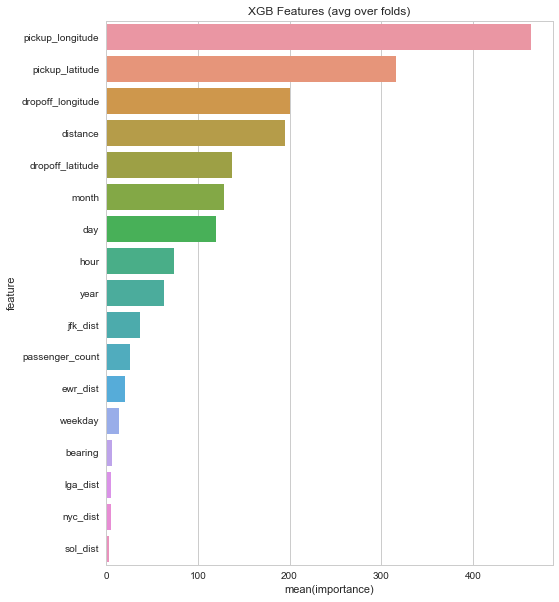

In [33]:
plt.figure(figsize=(8, 10))
sns.barplot(x="importance", y="feature", data=importance_df)
plt.title('XGB Features (avg over folds)')
plt.tight_layout
plt.show()